In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

### Database setup via SQLAlchemy

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
## REMOVE LATER ##
i = inspect(engine)
cols = i.get_columns('measurement')
for c in cols:
    print(c)

print('---')    
    
cols = i.get_columns('station')
for c in cols:
    print(c)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
---
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto'

In [13]:
ex = pd.read_sql_query("SELECT * FROM measurement WHERE date between '2016-08-23' and '2017-08-23'", engine)
print(ex)

         id      station        date  prcp  tobs
0      2364  USC00519397  2016-08-23  0.00  81.0
1      2365  USC00519397  2016-08-24  0.08  79.0
2      2366  USC00519397  2016-08-25  0.08  80.0
3      2367  USC00519397  2016-08-26  0.00  79.0
4      2368  USC00519397  2016-08-27  0.00  77.0
...     ...          ...         ...   ...   ...
2225  19546  USC00516128  2017-08-19  0.09  71.0
2226  19547  USC00516128  2017-08-20   NaN  78.0
2227  19548  USC00516128  2017-08-21  0.56  76.0
2228  19549  USC00516128  2017-08-22  0.50  76.0
2229  19550  USC00516128  2017-08-23  0.45  76.0

[2230 rows x 5 columns]


# Exploratory Climate Analysis

### Past 12 months of preciptation data 

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_12mo = pd.read_sql_query("SELECT date, prcp FROM measurement WHERE date between '2016-08-23' and '2017-08-23'", engine)

Text(0.5, 1.0, "Hawai'i precipitation: 8/23/2016 - 8/23/2017")

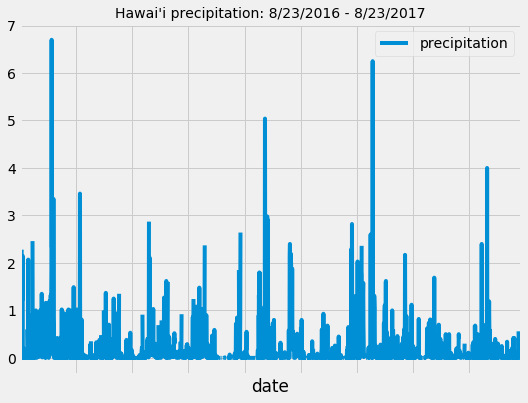

In [15]:
rain_12mo.set_index(keys='date', inplace=True)

# Sort the dataframe by date
rain_12mo.sort_index(inplace=True, ascending=True)
rain_12mo.rename(columns={'prcp': 'precipitation'}, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
rain_12mo.plot(y='precipitation', kind='line', figsize=(8,6))
plt.tick_params(labelbottom=False)   
plt.title('Hawai\'i precipitation: 8/23/2016 - 8/23/2017', fontsize=14)

### Precipitation summary

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_12mo_summary = rain_12mo.describe()
rain_12mo_summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Total number of stations

In [17]:
# Design a query to show how many stations are available in this dataset
station_count = engine.execute("SELECT count(id) as station_count FROM station")
for row in station_count: print(f'There are {row[0]} weather stations in this dataset.')

There are 9 weather stations in this dataset.


### Most active stations

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = engine.execute("SELECT s.station, count(m.id) as m_count FROM measurement m INNER JOIN station s on m.station = s.station GROUP BY s.station ORDER BY m_count DESC")
for row in active_stations: print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_temps = pd.read_sql_query("SELECT min(m.tobs) as min_temp, max(m.tobs) as max_temp, round(avg(m.tobs),1) as avg_temp \
                                 FROM measurement m \
                                 JOIN station s \
                                 ON m.station = s.station \
                                 WHERE s.station = 'USC00519281'", engine)
most_active_temps

,min_temp,max_temp,avg_temp
0,54.0,85.0,71.7


### Plotting 1y temperature data for most active station

Text(0.5, 0, 'Observed Temperature (F)')

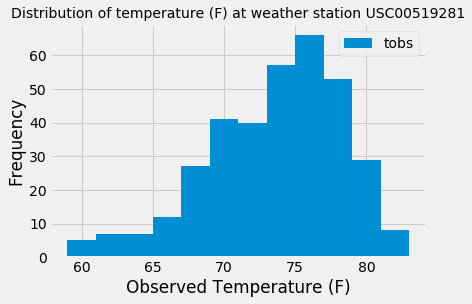

In [27]:
# Choose the station with the highest number of temperature observations.

temp_data = pd.read_sql_query("SELECT m.tobs, m.date, s.station \
                                 FROM measurement m \
                                 JOIN station s \
                                 ON m.station = s.station", engine)
t = temp_data.dropna().groupby('station')['tobs'].count()

t_most = t[t == max(t)] # USC00519281 is the measurement station with highest number of temp observations

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
t_most_temp_data = pd.read_sql_query("SELECT m.tobs, m.date, s.station \
                                 FROM measurement m \
                                 JOIN station s \
                                 ON m.station = s.station \
                                 WHERE m.date BETWEEN '2016-08-23' and '2017-08-23' \
                                 AND s.station = 'USC00519281'", engine)
t_most_temp_data.plot(y='tobs', kind='hist', bins=12)
plt.title("Distribution of temperature (F) at weather station USC00519281", fontsize=14)
plt.xlabel("Observed Temperature (F)")

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
past_year_temps = calc_temps('2016-08-23','2017-08-23')
print(past_year_temps)

[(58.0, 74.59058295964125, 87.0)]


# Stopped here - not required, bonus

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ptp = past_year_temps[0][2] - past_year_temps[0][0]

29.0

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


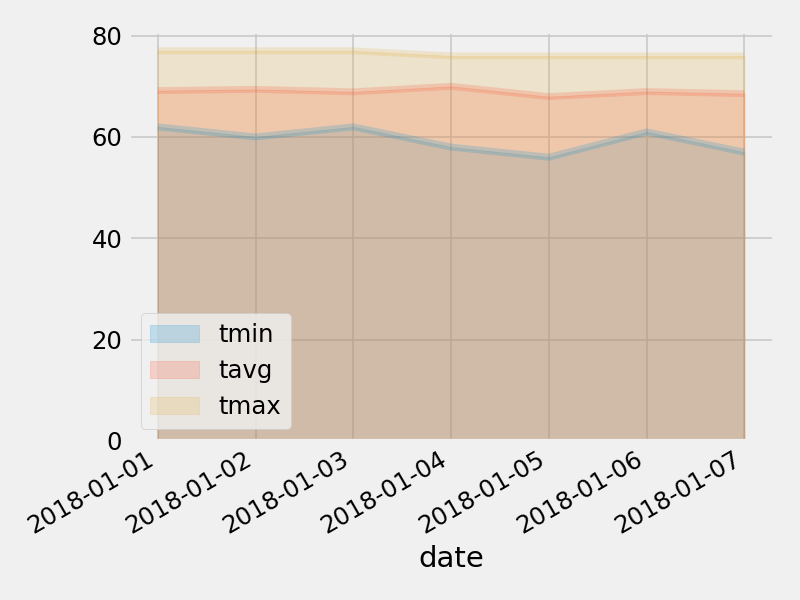

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
